#1. Installing  And Importing Libraries

In [1]:
!pip install -q transformers datasets evaluate
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding )
import pandas as pd
from tqdm import tqdm
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

#2. Setting Device To GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cpu":
    print("WARNING: GPU not found. Please go to Runtime > Change runtime type and select GPU.")

Using device: cuda


#3. Downloading And Preparing Dataset

In [4]:
print("Loading XNLI dataset...")
dataset_en = load_dataset("xnli", "en")

Loading XNLI dataset...


README.md: 0.00B [00:00, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

en/validation-00000-of-00001.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [5]:
# Create a small subset for fast training
TRAIN_SUBSET_SIZE = 13000
small_train_dataset = dataset_en["train"].shuffle(seed=42).select(range(TRAIN_SUBSET_SIZE))

# Keep the validation and test sets multilingual
TEST_SUBSET_SIZE = 1500
small_test_dataset = dataset_en['test'].shuffle(seed=42).select(range(TEST_SUBSET_SIZE))

VALIDATION_SUBSET_SIZE = 1500
small_validation_dataset = dataset_en['validation'].shuffle(seed=42).select(range(VALIDATION_SUBSET_SIZE))

# Creates the final subset dict
dataset_subset = DatasetDict({
    'train': small_train_dataset,
    'validation': small_validation_dataset,
    'test': small_test_dataset
})
print(f"\nCreated a ZERO-SHOT subset with {TRAIN_SUBSET_SIZE} (English-only) training examples:")
print(dataset_subset)


Created a ZERO-SHOT subset with 13000 (English-only) training examples:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 13000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1500
    })
})


#4. Loading Tokenizers

In [6]:
model_mono = "bert-base-uncased"
model_multi = "xlm-roberta-base"

print(f"\nLoading tokenizer for: {model_mono}")
tokenizer_mono = AutoTokenizer.from_pretrained(model_mono)

print(f"Loading tokenizer for: {model_multi}")
tokenizer_multi = AutoTokenizer.from_pretrained(model_multi)


Loading tokenizer for: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading tokenizer for: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [7]:
def preprocess_xnli(examples, tokenizer):
    # Ensure premise and hypothesis are lists of strings, handling potential non-string values
    premises = [str(p) if p is not None else "" for p in examples["premise"]]
    hypotheses = [str(h) if h is not None else "" for h in examples["hypothesis"]]
    return tokenizer(
        premises,
        hypotheses,
        truncation=True,
        max_length=256 )

#5. Tokenize Data For Both Models

In [8]:
print("\nTokenizing subset for BERT...")
tokenized_dataset_mono = dataset_subset.map(
    preprocess_xnli,
    batched=True,
    fn_kwargs={"tokenizer": tokenizer_mono},
    remove_columns=["premise", "hypothesis"],
    num_proc = 4 )

print("Tokenizing subset for XLM-RoBERTa...")
tokenized_dataset_multi = dataset_subset.map(
    preprocess_xnli,
    batched=True,
    fn_kwargs={"tokenizer": tokenizer_multi},
    remove_columns=["premise", "hypothesis"]
    ,num_proc = 4 )



Tokenizing subset for BERT...


Map (num_proc=4):   0%|          | 0/13000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1500 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1500 [00:00<?, ? examples/s]

Tokenizing subset for XLM-RoBERTa...


Map (num_proc=4):   0%|          | 0/13000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1500 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1500 [00:00<?, ? examples/s]

In [9]:
tokenized_dataset_mono = tokenized_dataset_mono.rename_column("label", "labels")
tokenized_dataset_multi = tokenized_dataset_multi.rename_column("label", "labels")

tokenized_dataset_mono.set_format("torch")
tokenized_dataset_multi.set_format("torch")

#6. Function For Computing Metrics

In [10]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"] }

#7. Loading MULTILINGUAL MODEL (XLM-R)

In [11]:
labels = ["entailment", "neutral", "contradiction"]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

model_multi = AutoModelForSequenceClassification.from_pretrained(
    model_multi,  # "xlm-roberta-base"
    num_labels=3,
    id2label=id2label,
    label2id=label2id )

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#8. Fine - Tuning Model

In [12]:
# Defines Training Arguments
training_args = TrainingArguments(
    output_dir="xlm-roberta-xnli-finetuned",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=150,
    save_strategy="steps",
    save_steps=150,
    load_best_model_at_end=True,
    logging_steps=100,
    push_to_hub=False,
    fp16 = True )

In [13]:
# Initializes Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_multi)

In [14]:
# Initializes Trainer
trainer_multi = Trainer(
    model=model_multi,
    args=training_args,
    train_dataset=tokenized_dataset_multi["train"],
    eval_dataset=tokenized_dataset_multi["validation"],
    tokenizer=tokenizer_multi,
    data_collator=data_collator,
    compute_metrics=compute_metrics )

In [15]:
# Starts Fine Tuning
print("Starting Fine-Tuning for XLM-RoBERTa :-  ")
trainer_multi.train()
print("--- Fine-Tuning Complete ---")

Starting Fine-Tuning for XLM-RoBERTa :-  


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: narendrapatel6321 (narendrapatel6321-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss,Validation Loss,Accuracy,F1
150,1.091900,0.907780,0.607333,0.607028
300,0.764600,0.715559,0.723333,0.721257
450,0.722200,0.649463,0.750000,0.751229
600,0.572100,0.645124,0.761333,0.762761
750,0.505400,0.665331,0.762667,0.763393
900,0.445300,0.649447,0.776000,0.777012


--- Fine-Tuning Complete ---


#9. Loading MONOLINGUAL MODEL (BERT)

In [16]:
# Loads Model
model_mono_loaded = AutoModelForSequenceClassification.from_pretrained(
    model_mono,  # This is "bert-base-uncased"
    num_labels=3,
    id2label=id2label,
    label2id=label2id )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#10. Fine - Tuning Model

In [17]:
# Defines Training Arguments
training_args_mono = TrainingArguments(
    output_dir="bert-xnli-finetuned",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=150,
    save_strategy="steps",
    save_steps=150,
    load_best_model_at_end=True,
    logging_steps=100,
    push_to_hub=False,
    fp16 = True )

In [18]:
# Initializes Data Collator
data_collator_mono = DataCollatorWithPadding(tokenizer=tokenizer_mono)

In [19]:
# Initializes Trainer
trainer_mono = Trainer(
    model=model_mono_loaded,
    args=training_args_mono,
    train_dataset=tokenized_dataset_mono["train"],
    eval_dataset=tokenized_dataset_mono["validation"],
    tokenizer=tokenizer_mono,
    data_collator=data_collator_mono,
    compute_metrics=compute_metrics )

In [20]:
# Starts Fine Tuning
print(f"Starting Fine-Tuning for Bert :- ")

trainer_mono.train()

print("--- Fine-Tuning Complete ---")

Starting Fine-Tuning for Bert :- 


Step,Training Loss,Validation Loss,Accuracy,F1
150,1.014700,0.751862,0.688000,0.687562
300,0.615700,0.684655,0.716000,0.717387
450,0.582800,0.683467,0.726000,0.727672
600,0.441400,0.682522,0.733333,0.735469
750,0.331800,0.751735,0.730000,0.731607
900,0.284800,0.764878,0.729333,0.731088


--- Fine-Tuning Complete ---


#11. Efficiency Evaluation

In [21]:
import datasets
import transformers

# This hides all "info" messages like "Generating train split..."
# It will only show messages if there is an actual ERROR.
datasets.logging.set_verbosity(datasets.logging.ERROR)
transformers.logging.set_verbosity(transformers.logging.ERROR)

# This specifically hides the "Map: 100%..." progress bar
datasets.logging.disable_progress_bar()

In [22]:
results_list = []
languages = [
    'en', 'fr', 'es', 'de', 'el', 'bg', 'ru', 'tr',
    'ar', 'vi', 'th', 'zh', 'hi', 'sw', 'ur'
]

print("Preprocessing all language test sets...")

# Loads and Tokenizes All test sets before prediction
tokenized_test_sets_multi = {}
tokenized_test_sets_mono = {}

for lang in tqdm(languages, desc="Loading/Tokenizing test sets"):
    lang_test_set = load_dataset("xnli", lang, split="test")

    # Tokenize for XLM-R
    tokenized_test_sets_multi[lang] = lang_test_set.map(
        preprocess_xnli,
        batched=True,
        fn_kwargs={"tokenizer": tokenizer_multi},
        remove_columns=["premise", "hypothesis"]
    ).rename_column("label", "labels")

    # Tokenize for BERT
    tokenized_test_sets_mono[lang] = lang_test_set.map(
        preprocess_xnli,
        batched=True,
        fn_kwargs={"tokenizer": tokenizer_mono},
        remove_columns=["premise", "hypothesis"]
    ).rename_column("label", "labels")

print(f"Starting evaluation on all {len(languages)} languages :- ")


#Prediction
for lang in tqdm(languages, desc="Evaluating all languages"):

    # Evaluate Multilingual Model (XLM-R)
    print(f"\nEvaluating XLM-RoBERTa on: {lang}")
    multi_metrics = trainer_multi.predict(tokenized_test_sets_multi[lang])
    results_list.append({
        "model": "XLM-RoBERTa",
        "language": lang,
        "accuracy": multi_metrics.metrics['test_accuracy'],
        "f1": multi_metrics.metrics['test_f1']
    })

    # Evaluate Monolingual Model (BERT)
    print(f"Evaluating BERT on: {lang}")
    mono_metrics = trainer_mono.predict(tokenized_test_sets_mono[lang])
    results_list.append({
        "model": "BERT",
        "language": lang,
        "accuracy": mono_metrics.metrics['test_accuracy'],
        "f1": mono_metrics.metrics['test_f1']
    })

print("\n--- Evaluation Complete ---")

Preprocessing all language test sets...


Loading/Tokenizing test sets:   7%|▋         | 1/15 [00:05<01:11,  5.07s/it]

fr/train-00000-of-00001.parquet:   0%|          | 0.00/55.4M [00:00<?, ?B/s]

fr/test-00000-of-00001.parquet:   0%|          | 0.00/360k [00:00<?, ?B/s]

fr/validation-00000-of-00001.parquet:   0%|          | 0.00/183k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  13%|█▎        | 2/15 [00:16<01:57,  9.02s/it]

es/train-00000-of-00001.parquet:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

es/test-00000-of-00001.parquet:   0%|          | 0.00/342k [00:00<?, ?B/s]

es/validation-00000-of-00001.parquet:   0%|          | 0.00/173k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  20%|██        | 3/15 [00:23<01:36,  8.06s/it]

de/train-00000-of-00001.parquet:   0%|          | 0.00/55.4M [00:00<?, ?B/s]

de/test-00000-of-00001.parquet:   0%|          | 0.00/356k [00:00<?, ?B/s]

de/validation-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  27%|██▋       | 4/15 [00:40<02:04, 11.34s/it]

el/train-00000-of-00001.parquet:   0%|          | 0.00/73.8M [00:00<?, ?B/s]

el/test-00000-of-00001.parquet:   0%|          | 0.00/490k [00:00<?, ?B/s]

el/validation-00000-of-00001.parquet:   0%|          | 0.00/247k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  33%|███▎      | 5/15 [00:48<01:41, 10.14s/it]

bg/train-00000-of-00001.parquet:   0%|          | 0.00/65.4M [00:00<?, ?B/s]

bg/test-00000-of-00001.parquet:   0%|          | 0.00/447k [00:00<?, ?B/s]

bg/validation-00000-of-00001.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  40%|████      | 6/15 [00:55<01:24,  9.33s/it]

ru/train-00000-of-00001.parquet:   0%|          | 0.00/70.0M [00:00<?, ?B/s]

ru/test-00000-of-00001.parquet:   0%|          | 0.00/477k [00:00<?, ?B/s]

ru/validation-00000-of-00001.parquet:   0%|          | 0.00/239k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  47%|████▋     | 7/15 [01:05<01:15,  9.49s/it]

tr/train-00000-of-00001.parquet:   0%|          | 0.00/48.0M [00:00<?, ?B/s]

tr/test-00000-of-00001.parquet:   0%|          | 0.00/338k [00:00<?, ?B/s]

tr/validation-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  53%|█████▎    | 8/15 [01:11<00:59,  8.43s/it]

ar/train-00000-of-00001.parquet:   0%|          | 0.00/58.6M [00:00<?, ?B/s]

ar/test-00000-of-00001.parquet:   0%|          | 0.00/392k [00:00<?, ?B/s]

ar/validation-00000-of-00001.parquet:   0%|          | 0.00/194k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  60%|██████    | 9/15 [01:19<00:48,  8.02s/it]

vi/train-00000-of-00001.parquet:   0%|          | 0.00/57.1M [00:00<?, ?B/s]

vi/test-00000-of-00001.parquet:   0%|          | 0.00/364k [00:00<?, ?B/s]

vi/validation-00000-of-00001.parquet:   0%|          | 0.00/186k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  67%|██████▋   | 10/15 [01:25<00:37,  7.54s/it]

th/train-00000-of-00001.parquet:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

th/test-00000-of-00001.parquet:   0%|          | 0.00/503k [00:00<?, ?B/s]

th/validation-00000-of-00001.parquet:   0%|          | 0.00/252k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  73%|███████▎  | 11/15 [01:34<00:32,  8.09s/it]

zh/train-00000-of-00001.parquet:   0%|          | 0.00/47.8M [00:00<?, ?B/s]

zh/test-00000-of-00001.parquet:   0%|          | 0.00/310k [00:00<?, ?B/s]

zh/validation-00000-of-00001.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  80%|████████  | 12/15 [01:45<00:26,  8.81s/it]

hi/train-00000-of-00001.parquet:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

hi/test-00000-of-00001.parquet:   0%|          | 0.00/493k [00:00<?, ?B/s]

hi/validation-00000-of-00001.parquet:   0%|          | 0.00/249k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  87%|████████▋ | 13/15 [01:53<00:17,  8.55s/it]

sw/train-00000-of-00001.parquet:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

sw/test-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

sw/validation-00000-of-00001.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

Loading/Tokenizing test sets:  93%|█████████▎| 14/15 [02:00<00:08,  8.29s/it]

ur/train-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

ur/test-00000-of-00001.parquet:   0%|          | 0.00/428k [00:00<?, ?B/s]

ur/validation-00000-of-00001.parquet:   0%|          | 0.00/216k [00:00<?, ?B/s]

Loading/Tokenizing test sets: 100%|██████████| 15/15 [02:08<00:00,  8.57s/it]


Starting evaluation on all 15 languages :- 


Evaluating all languages:   0%|          | 0/15 [00:00<?, ?it/s]


Evaluating XLM-RoBERTa on: en


Evaluating BERT on: en


Evaluating all languages:   7%|▋         | 1/15 [00:09<02:17,  9.84s/it]


Evaluating XLM-RoBERTa on: fr


Evaluating BERT on: fr


Evaluating all languages:  13%|█▎        | 2/15 [00:24<02:43, 12.57s/it]


Evaluating XLM-RoBERTa on: es


Evaluating BERT on: es


Evaluating all languages:  20%|██        | 3/15 [00:37<02:33, 12.77s/it]


Evaluating XLM-RoBERTa on: de


Evaluating BERT on: de


Evaluating all languages:  27%|██▋       | 4/15 [00:50<02:24, 13.12s/it]


Evaluating XLM-RoBERTa on: el


Evaluating BERT on: el


Evaluating all languages:  33%|███▎      | 5/15 [01:14<02:49, 16.90s/it]


Evaluating XLM-RoBERTa on: bg


Evaluating BERT on: bg


Evaluating all languages:  40%|████      | 6/15 [01:37<02:50, 18.91s/it]


Evaluating XLM-RoBERTa on: ru


Evaluating BERT on: ru


Evaluating all languages:  47%|████▋     | 7/15 [02:01<02:43, 20.47s/it]


Evaluating XLM-RoBERTa on: tr


Evaluating BERT on: tr


Evaluating all languages:  53%|█████▎    | 8/15 [02:14<02:08, 18.36s/it]


Evaluating XLM-RoBERTa on: ar


Evaluating BERT on: ar


Evaluating all languages:  60%|██████    | 9/15 [02:35<01:53, 19.00s/it]


Evaluating XLM-RoBERTa on: vi


Evaluating BERT on: vi


Evaluating all languages:  67%|██████▋   | 10/15 [02:49<01:27, 17.47s/it]


Evaluating XLM-RoBERTa on: th


Evaluating BERT on: th


Evaluating all languages:  73%|███████▎  | 11/15 [02:57<00:57, 14.49s/it]


Evaluating XLM-RoBERTa on: zh


Evaluating BERT on: zh


Evaluating all languages:  80%|████████  | 12/15 [03:07<00:39, 13.29s/it]


Evaluating XLM-RoBERTa on: hi


Evaluating BERT on: hi


Evaluating all languages:  87%|████████▋ | 13/15 [03:26<00:29, 14.90s/it]


Evaluating XLM-RoBERTa on: sw


Evaluating BERT on: sw


Evaluating all languages:  93%|█████████▎| 14/15 [03:39<00:14, 14.38s/it]


Evaluating XLM-RoBERTa on: ur


Evaluating BERT on: ur


Evaluating all languages: 100%|██████████| 15/15 [04:00<00:00, 16.06s/it]


--- Evaluation Complete ---


In [23]:
# Displays Final Results Table
results_df = pd.DataFrame(results_list)
print(results_df.sort_values(by="language"))

          model language  accuracy        f1
17         BERT       ar  0.333134  0.172175
16  XLM-RoBERTa       ar  0.631537  0.627983
10  XLM-RoBERTa       bg  0.689621  0.690204
11         BERT       bg  0.336527  0.184614
6   XLM-RoBERTa       de  0.670259  0.670740
7          BERT       de  0.396806  0.356808
9          BERT       el  0.334930  0.173513
8   XLM-RoBERTa       el  0.671856  0.671785
0   XLM-RoBERTa       en  0.742515  0.744196
1          BERT       en  0.729741  0.731461
4   XLM-RoBERTa       es  0.701996  0.703004
5          BERT       es  0.453493  0.418526
3          BERT       fr  0.397206  0.344756
2   XLM-RoBERTa       fr  0.695808  0.697146
25         BERT       hi  0.337126  0.203337
24  XLM-RoBERTa       hi  0.622954  0.617051
12  XLM-RoBERTa       ru  0.663872  0.663719
13         BERT       ru  0.338124  0.185792
27         BERT       sw  0.387824  0.379314
26  XLM-RoBERTa       sw  0.600798  0.597247
20  XLM-RoBERTa       th  0.635130  0.632181
21        

In [24]:
# Restore Default Logging
# This brings all the "Generating split..." messages back
datasets.logging.set_verbosity(datasets.logging.INFO)
transformers.logging.set_verbosity(transformers.logging.INFO)

# This brings the "Map: 100%..." progress bar back
datasets.logging.enable_progress_bar()

#12. Visualization

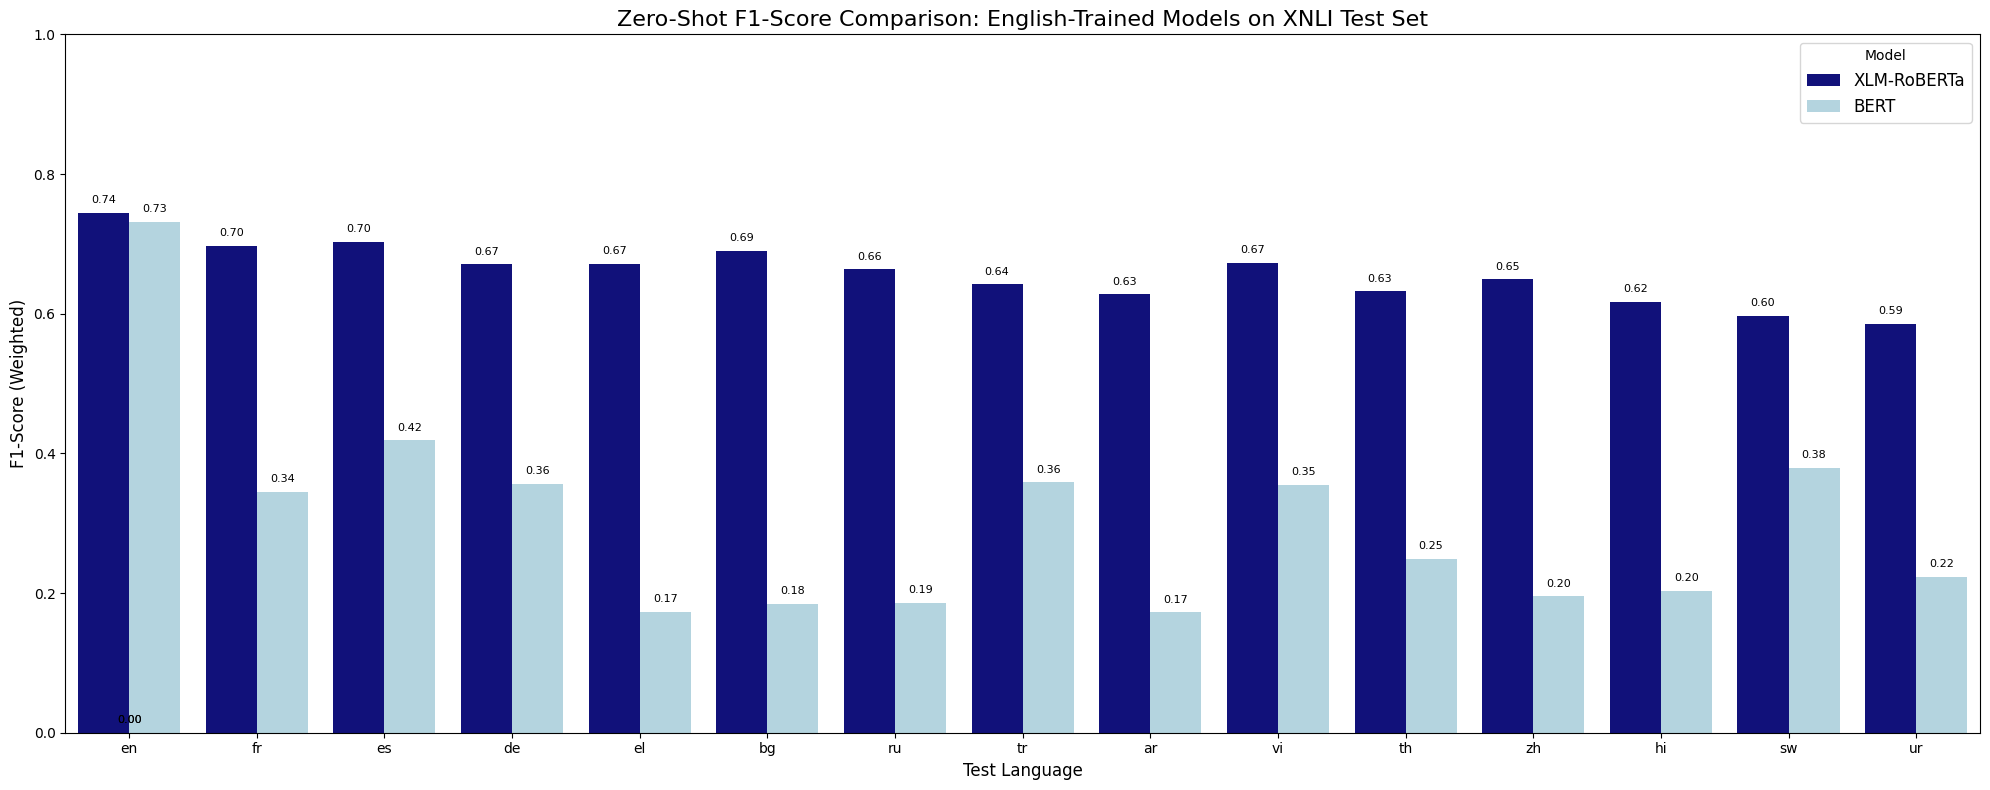

In [25]:
# Sets up the Figure
plt.figure(figsize=(20, 8))

# Creates the Grouped Bar Plot
barplot = sns.barplot(
    data=results_df,
    x='language',  # Languages on the x-axis
    y='f1',        # F1-score on the y-axis
    hue='model',   # Group by model (BERT vs. XLM-R)
    palette={'BERT': 'lightblue', 'XLM-RoBERTa': 'darkblue'}
)

# Customizes the Plot
plt.title('Zero-Shot F1-Score Comparison: English-Trained Models on XNLI Test Set', fontsize=16)
plt.xlabel('Test Language', fontsize=12)
plt.ylabel('F1-Score (Weighted)', fontsize=12)
plt.legend(title='Model', fontsize=12)
plt.ylim(0, 1.0) # Set y-axis from 0 to 1.0

# Add text labels (the F1-score) on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=8)

# Shows the Plot
plt.tight_layout()
plt.show()

#13. Confusion Metrix for Both Models


***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Generating Confusion Matrix for English :- 


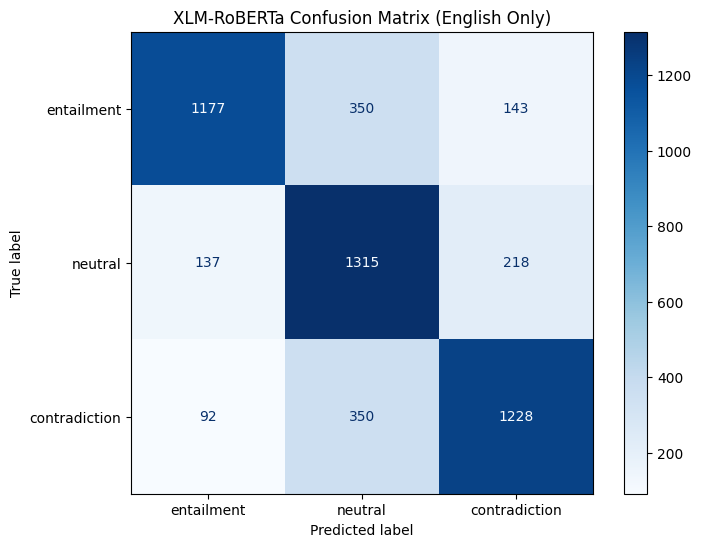

In [26]:
#defins labels
labels = ["entailment", "neutral", "contradiction"]

print("Generating Confusion Matrix for English :- ")

# Get predictions for the 'en' (English) test set
en_test_set = tokenized_test_sets_multi['en']
en_preds = trainer_multi.predict(en_test_set)

# Get the predicted class (the one with the highest logit)
en_predicted_labels = np.argmax(en_preds.predictions, axis=1)
en_true_labels = en_preds.label_ids

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    en_true_labels,
    en_predicted_labels,
    display_labels=labels,
    cmap='Blues',
    ax=ax
)
plt.title('XLM-RoBERTa Confusion Matrix (English Only)')
plt.show()


***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Generating Confusion Matrix for BERT (English) :- 


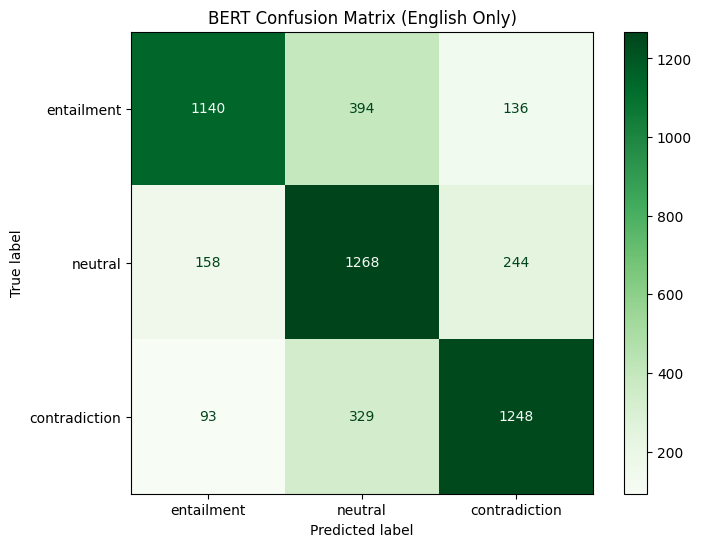

In [27]:
print("Generating Confusion Matrix for BERT (English) :- ")

# Get predictions for the 'en' (English) test set using the mono trainer
en_test_set_mono = tokenized_test_sets_mono['en']
en_preds_mono = trainer_mono.predict(en_test_set_mono)


en_predicted_labels_mono = np.argmax(en_preds_mono.predictions, axis=1)
en_true_labels_mono = en_preds_mono.label_ids

# Creates the plot
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    en_true_labels_mono,
    en_predicted_labels_mono,
    display_labels=labels,
    cmap='Greens',
    ax=ax
)
plt.title('BERT Confusion Matrix (English Only)')
plt.show()

In [28]:
print("Generating Confusion Matrix for All Non-English Languages :- ")

# gathers all predictions and labels from non-English sets
all_non_en_preds = []
all_non_en_labels = []

# Loops through all languages, skipping English
for lang in tqdm(languages, desc="Gathering non-English predictions"):
    if lang == 'en':
        continue

    # Get predictions for this language
    lang_test_set = tokenized_test_sets_multi[lang]
    lang_preds = trainer_multi.predict(lang_test_set)

    # Add the results to lists
    all_non_en_preds.extend(np.argmax(lang_preds.predictions, axis=1))
    all_non_en_labels.extend(lang_preds.label_ids)

Generating Confusion Matrix for All Non-English Languages :- 


Gathering non-English predictions:   0%|          | 0/15 [00:00<?, ?it/s]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  13%|█▎        | 2/15 [00:05<00:38,  3.00s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  20%|██        | 3/15 [00:11<00:46,  3.90s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  27%|██▋       | 4/15 [00:16<00:49,  4.50s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  33%|███▎      | 5/15 [00:22<00:50,  5.09s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  40%|████      | 6/15 [00:28<00:47,  5.27s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  47%|████▋     | 7/15 [00:34<00:42,  5.35s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  53%|█████▎    | 8/15 [00:39<00:36,  5.24s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  60%|██████    | 9/15 [00:44<00:31,  5.26s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  67%|██████▋   | 10/15 [00:49<00:26,  5.36s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  73%|███████▎  | 11/15 [00:55<00:21,  5.33s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  80%|████████  | 12/15 [00:59<00:15,  5.06s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  87%|████████▋ | 13/15 [01:05<00:10,  5.35s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions:  93%|█████████▎| 14/15 [01:10<00:05,  5.31s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English predictions: 100%|██████████| 15/15 [01:16<00:00,  5.11s/it]


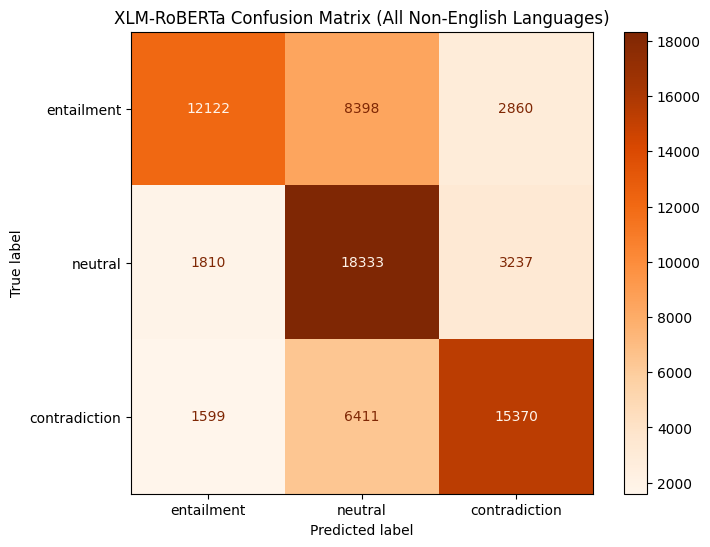

In [29]:
# Creates the plot for the combined non-English results
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    all_non_en_labels,
    all_non_en_preds,
    display_labels=labels,
    cmap='Oranges',
    ax=ax
)
plt.title('XLM-RoBERTa Confusion Matrix (All Non-English Languages)')
plt.show()

In [30]:
print("Generating Confusion Matrix for BERT (All Non-English Languages) := ")

# Gathers all predictions and labels from non-English sets
all_non_en_preds_mono = []
all_non_en_labels_mono = []

# Loops through all languages, skipping English
for lang in tqdm(languages, desc="Gathering non-English BERT predictions"):
    if lang == 'en':
        continue

    # Get predictions for this language
    lang_test_set_mono = tokenized_test_sets_mono[lang]
    lang_preds_mono = trainer_mono.predict(lang_test_set_mono)

    # Add the results to lists
    all_non_en_preds_mono.extend(np.argmax(lang_preds_mono.predictions, axis=1))
    all_non_en_labels_mono.extend(lang_preds_mono.label_ids)

Generating Confusion Matrix for BERT (All Non-English Languages) := 


Gathering non-English BERT predictions:   0%|          | 0/15 [00:00<?, ?it/s]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  13%|█▎        | 2/15 [00:07<00:48,  3.76s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  20%|██        | 3/15 [00:15<01:04,  5.35s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  27%|██▋       | 4/15 [00:23<01:10,  6.39s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  33%|███▎      | 5/15 [00:41<01:43, 10.38s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  40%|████      | 6/15 [00:58<01:54, 12.69s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  47%|████▋     | 7/15 [01:16<01:54, 14.35s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  53%|█████▎    | 8/15 [01:25<01:28, 12.61s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  60%|██████    | 9/15 [01:40<01:19, 13.33s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  67%|██████▋   | 10/15 [01:48<00:59, 11.87s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  73%|███████▎  | 11/15 [01:50<00:35,  8.96s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  80%|████████  | 12/15 [01:57<00:24,  8.16s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  87%|████████▋ | 13/15 [02:09<00:19,  9.54s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions:  93%|█████████▎| 14/15 [02:17<00:09,  9.02s/it]
***** Running Prediction *****
  Num examples = 5010
  Batch size = 64


Gathering non-English BERT predictions: 100%|██████████| 15/15 [02:33<00:00, 10.24s/it]


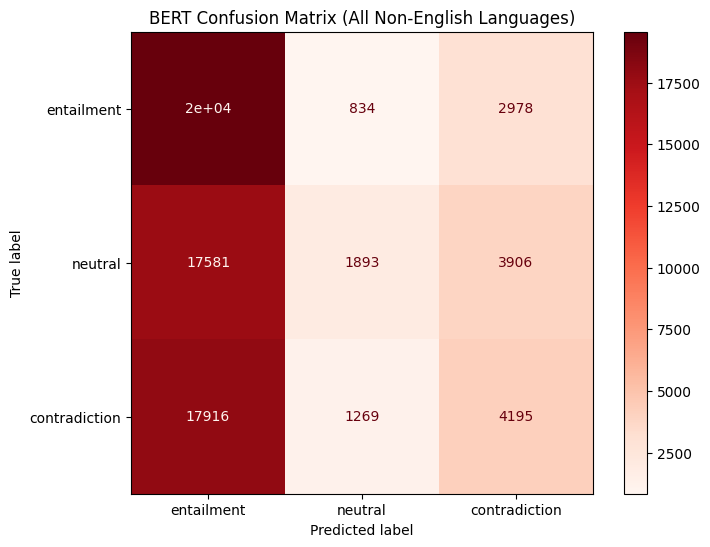

In [31]:
# Creates the plot for the combined non-English results
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    all_non_en_labels_mono,
    all_non_en_preds_mono,
    display_labels=labels,
    cmap='Reds',
    ax=ax
)
plt.title('BERT Confusion Matrix (All Non-English Languages)')
plt.show()

#14. Demo Of Models

In [32]:
# Loads multilingual model and tokenizer
model_multi_demo = trainer_multi.model.to(device).eval()
tokenizer_multi_demo = tokenizer_multi

# Loads monolingual model and tokenizer
model_mono_demo = trainer_mono.model.to(device).eval()
tokenizer_mono_demo = tokenizer_mono

print("Both models are loaded and ready for the demo.")


# Creats prediction functions
def predict_nli(premise, hypothesis, model_choice):

    if model_choice == "XLM-RoBERTa (Multilingual)" :
        model = model_multi_demo
        tokenizer = tokenizer_multi_demo
    else:
        model = model_mono_demo
        tokenizer = tokenizer_mono_demo

    inputs = tokenizer(
        premise,
        hypothesis,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Gets predictions
    with torch.no_grad():
        logits = model(**inputs).logits

    scores = torch.softmax(logits, dim=1)[0].cpu().numpy()
    confidences = {labels[i]: float(scores[i]) for i in range(len(labels))}

    return confidences

Both models are loaded and ready for the demo.


#15. Gradio Interface

In [35]:
demo = gr.Interface(
    fn=predict_nli,
    inputs=[
        gr.Textbox(label="Premise", lines=3, placeholder="Type the first sentence here..."),
        gr.Textbox(label="Hypothesis", lines=3, placeholder="Type the second sentence here..."),

        gr.Radio(
            label="Model Choice",
            choices=["XLM-RoBERTa (Multilingual)", "BERT (Monolingual)"],
            value="XLM-RoBERTa (Multilingual)"
        )
    ],
    outputs=gr.Label(label="Prediction", num_top_classes=3),
    title="Cross-Lingual NLI: XLM-RoBERTa vs. BERT",
    description="Compare a multilingual and monolingual model. "
                "Both were fine-tuned **only on English**. "
                "Try non-English text to see the zero-shot difference!",
    examples=[
        # English example
        ["A man is playing a guitar.", "A man is playing an instrument.", "XLM-RoBERTa (Multilingual)"],
        # Non-English example (French)
        ["Un homme joue de la guitare.", "Un homme joue d'un instrument.", "XLM-RoBERTa (Multilingual)"],
        # Same Non-English example for BERT
        ["Un homme joue de la guitare.", "Un homme joue d'un instrument.", "BERT (Monolingual)"]
    ]
)

# Launchs the demo
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8c1b54a4d3c00ccdae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ce3f4f0a93bca110ba.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://8c1b54a4d3c00ccdae.gradio.live
